# Group Connection Testing


In this notebook we will be testing whether the hemispheres/segments come from an stochastic block model, which models graphs containing communities, in which subsets of nodes within each community are characterized as being connected to each other with particular edge densities. Here, our communities are determined by the classes of the neurons within each hemisphere/segment, which we are considering can be interneuron, motorneuron, or sensory neuron.

In [1]:
import logging
import pandas as pd
import numpy as np
import csv
import networkx as nx
import itertools
import seaborn as sns
from pathlib import Path
from networkx import from_pandas_adjacency
from itertools import chain, combinations
from matplotlib import pyplot as plt
from collections import namedtuple
from graspologic.inference import group_connection_test
from graspologic.plot import heatmap, adjplot
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations, load_left_adj_labels, load_right_adj_labels, load_head_adj_labels, load_pygidium_adj_labels, load_0_adj_labels, load_1_adj_labels, load_2_adj_labels, load_3_adj_labels


In [2]:
folder = _get_folder()
annotations = load_connectome_normal_lcc_annotations()
folder

PosixPath('/Users/kareefullah/Desktop/NeuroData/neurodata/platy-data/docs/outputs')

The following blocks of code generate dataframes, where the skids_df represent the skids of interest in the hemispheres/segments and labels_df represent the corresponding labels of the classes of the neurons

In [61]:
left_adj, _ = load_left_adj_labels()
left_adj_index = list(left_adj.index)

right_adj, _ = load_right_adj_labels()
right_adj_index = list(right_adj.index)

all_hemi_index  = left_adj_index + right_adj_index
all_hemi_index = [int(i) for i in all_hemi_index]

skids_hemis = {"l": [], "r": []}
labels_hemis = {"l": [], "r": []}
poss_labels = ["s", "i", "m"]

#add skids and labels for hemis;
for key in skids_hemis:
    for i in range(len(annotations["skids"])):

        #check if the skid is in the left/right adj (normal, lcc), and the side is left or right, and the class exists as sensory, motor, or inter
        if(annotations["skids"][i] in all_hemi_index and annotations["side"][i]==key and annotations["class"][i] in poss_labels):
            skids_hemis[key].append(annotations["skids"][i])
            labels_hemis[key].append(annotations["class"][i])

#convert dicts to dataframes
skids_hemis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_hemis.items()]))
labels_hemis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in labels_hemis.items()]))
skids_hemis_df.to_csv(folder / "skids_hemis_classes.csv")
labels_hemis_df.to_csv(folder / "labels_hemis_classes.csv")

In [62]:
head_adj, _ = load_head_adj_labels()
head_adj_index = list(head_adj.index)

pyg_adj, _ = load_pygidium_adj_labels()
pyg_adj_index = list(pyg_adj.index)

#adj_0, _ = load_0_adj_labels()
#adj_0_index = list(adj_0.index)

adj_1, _ = load_1_adj_labels()
adj_1_index = list(adj_1.index)

adj_2, _ = load_2_adj_labels()
adj_2_index = list(adj_2.index)

adj_3, _ = load_3_adj_labels()
adj_3_index = list(adj_3.index)

all_segs_index  = head_adj_index + pyg_adj_index + adj_1_index + adj_2_index + adj_3_index
all_segs_index = [int(i) for i in all_segs_index]

skids_segs = {"head": [], "pygidium": [], "1": [], "2": [], "3": []}
labels_segs = {"head": [], "pygidium": [], "1": [], "2": [], "3": []}

for key in skids_segs:
    for i in range(len(annotations["skids"])):
        if(annotations["skids"][i] in all_segs_index and annotations["segment"][i]==key and annotations["class"][i] in poss_labels):
            skids_segs[key].append(annotations["skids"][i])
            labels_segs[key].append(annotations["class"][i])

skids_segs_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_segs.items()]))
labels_segs_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in labels_segs.items()]))
skids_segs_df.to_csv(folder / "skids_segs_classes.csv")
labels_segs_df.to_csv(folder / "labels_segs_classes.csv")

In [63]:
new_folder = Path.joinpath(folder, "group_connection_plots")
new_folder

PosixPath('/Users/kareefullah/Desktop/NeuroData/neurodata/platy-data/docs/outputs/group_connection_plots')

In [64]:
#comparison for hemis
count_hemis = {"l" : {"s": 0, "i": 0, "m": 0}, "r": {"s": 0, "i": 0, "m": 0}}

for key in count_hemis:
    for i in range(len(labels_hemis[key])):
        count_hemis[key][labels_hemis[key][i]] += 1

# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "s", "i", "m"
list_counts_hemis = []
class_label_hemis = []
hemi_label = []
# loop through "l" and "r"
for key in count_hemis:
    # loop through "s", "i", "m"
    for inner_key in count_hemis[key]:
        # append "s" "i" or "m"
        class_label_hemis.append(inner_key)
        # add 1 to the count of the respective class label in the respective key of count_hemis
        list_counts_hemis.append(count_hemis[key][inner_key])
        # append the outer key from count_hemis
        hemi_label.append(key)

label_counts = list(zip(class_label_hemis, list_counts_hemis, hemi_label))
df_hemis = pd.DataFrame(label_counts, columns = ["class", "count", "side"])
df_hemis.to_csv(new_folder / "hemi_classes_counts.csv")
df_hemis

,class,count,side
0,s,236,l
1,i,362,l
2,m,91,l
3,s,229,r
4,i,367,r
5,m,96,r


We make barplots for the counts of each of the classes across the hemispheres/segments using the dictionaries we generated above

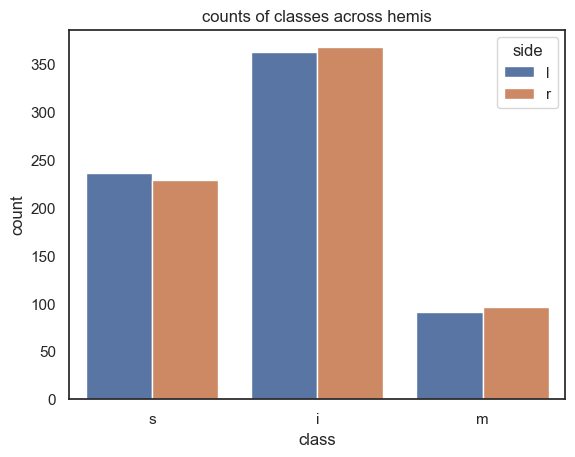

In [65]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="side", data=df_hemis)
plt.title("counts of classes across hemis")
plt.savefig(new_folder / "hemi_classes_barplot.png")

In [66]:

#comparison for segments
count_segs = {"head" : {"s": 0, "i": 0, "m": 0},
              "pygidium": {"s": 0, "i": 0, "m": 0},
              "1" : {"s": 0, "i": 0, "m": 0},
              "2" : {"s": 0, "i": 0, "m": 0},
              "3" : {"s": 0, "i": 0, "m": 0},}

for key in count_segs:
    for i in range(len(labels_segs[key])):
        count_segs[key][labels_segs[key][i]] += 1
print(count_segs)
# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "s", "i", "m"
list_counts_segs = []
class_label_segs = []
segs_label = []
# loop through "l" and "r"
for key in count_segs:
    # loop through "s", "i", "m"
    for inner_key in count_segs[key]:
        # append "s" "i" or "m"
        class_label_segs.append(inner_key)
        # add 1 to the count of the respective class label in the respective key of count_hemis
        list_counts_segs.append(count_segs[key][inner_key])
        # append the outer key from count_hemis
        segs_label.append(key)

label_counts_segs = list(zip(class_label_segs, list_counts_segs, segs_label))
df_segs = pd.DataFrame(label_counts_segs, columns = ["class", "count", "segment"])
df_segs.to_csv(new_folder / "segs_classes_counts.csv")
df_segs

{'head': {'s': 310, 'i': 339, 'm': 22}, 'pygidium': {'s': 40, 'i': 13, 'm': 3}, '1': {'s': 21, 'i': 113, 'm': 45}, '2': {'s': 40, 'i': 150, 'm': 67}, '3': {'s': 40, 'i': 98, 'm': 49}}


,class,count,segment
0,s,310,head
1,i,339,head
2,m,22,head
3,s,40,pygidium
4,i,13,pygidium
5,m,3,pygidium
6,s,21,1
7,i,113,1
8,m,45,1
9,s,40,2


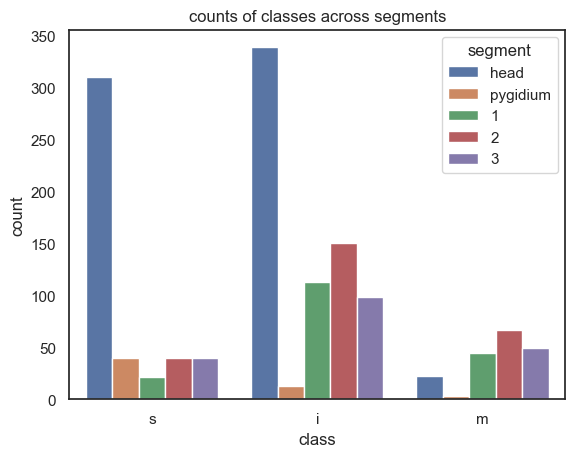

In [67]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="segment", data=df_segs)
plt.title("counts of classes across segments")
plt.savefig(new_folder / "segs_classes_barplot.png")

We will now visualize the adjs of the hemispheres/segments, in which the nodes will be grouped into communities of sensory, motor, or interneurons

In [68]:
from pkg.platy import load_0_adj_labels, load_1_adj_labels, load_2_adj_labels, load_3_adj_labels, load_right_adj_labels, load_left_adj_labels, load_head_adj_labels, load_pygidium_adj_labels

#block for loading adjs/labels

#hemis
left_adj, left_labels = load_left_adj_labels()
right_adj, right_labels = load_right_adj_labels()

#segments
head_adj, head_labels = load_head_adj_labels()
pyg_adj, pyg_labels = load_pygidium_adj_labels()
#adj_0, labels_0 = load_0_adj_labels()
adj_1, labels_1 = load_1_adj_labels()
adj_2, labels_2 = load_2_adj_labels()
adj_3, labels_3 = load_3_adj_labels()

In [69]:
#lists for adjs/labels/names
hemi_adjs = [left_adj, right_adj]
for i, val in enumerate(hemi_adjs):
    hemi_adjs[i] = val.to_numpy()

segment_adjs = [head_adj, pyg_adj, adj_1, adj_2, adj_3]
for i, val in enumerate(segment_adjs):
    segment_adjs[i] = val.to_numpy()
all_adjs = hemi_adjs + segment_adjs

hemi_labels = [left_labels, right_labels]
segment_labels = [head_labels, pyg_labels, labels_1, labels_2, labels_3]
all_labels = hemi_labels + segment_labels

hemi_names = ["left", "right"]
segment_names = ["head", "pygidium", "1", "2", "3"]
all_names = hemi_names + segment_names

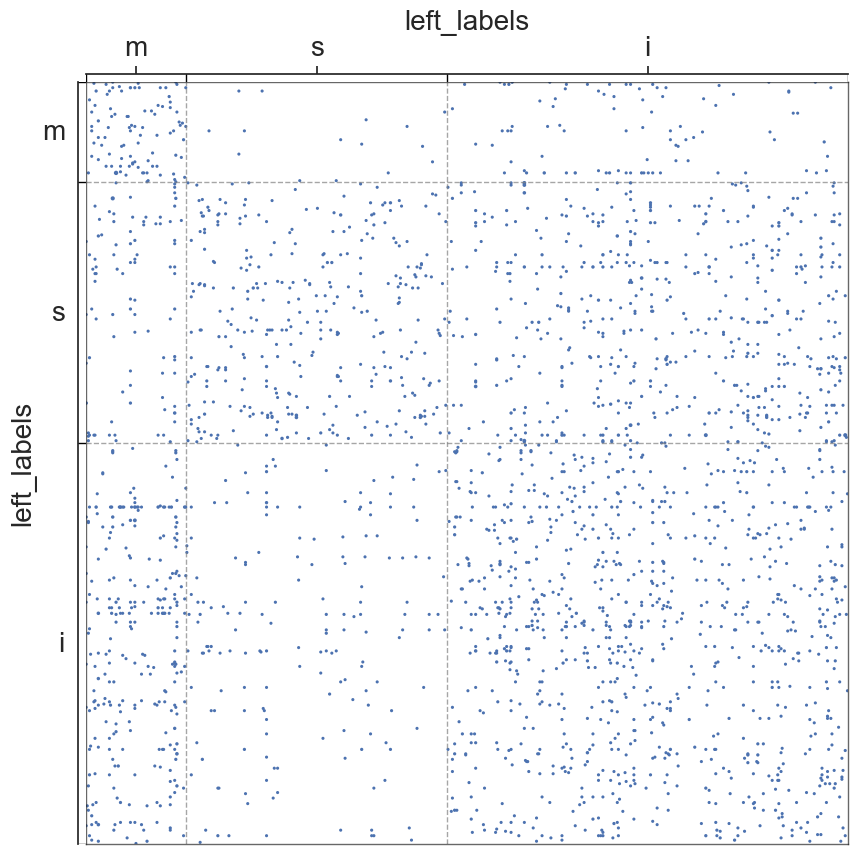

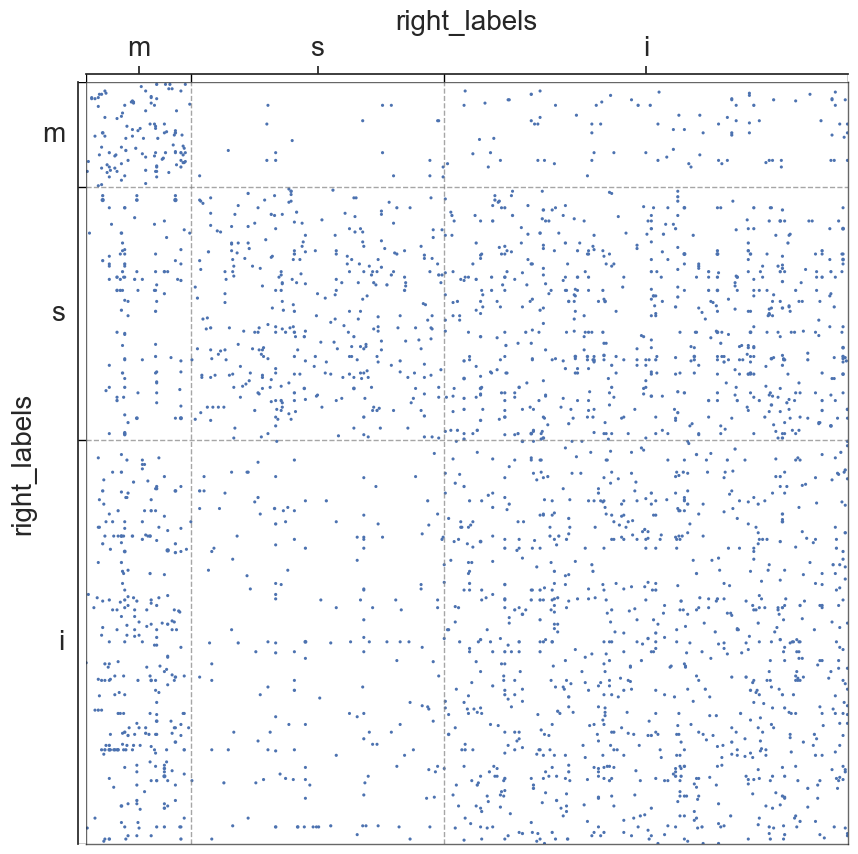

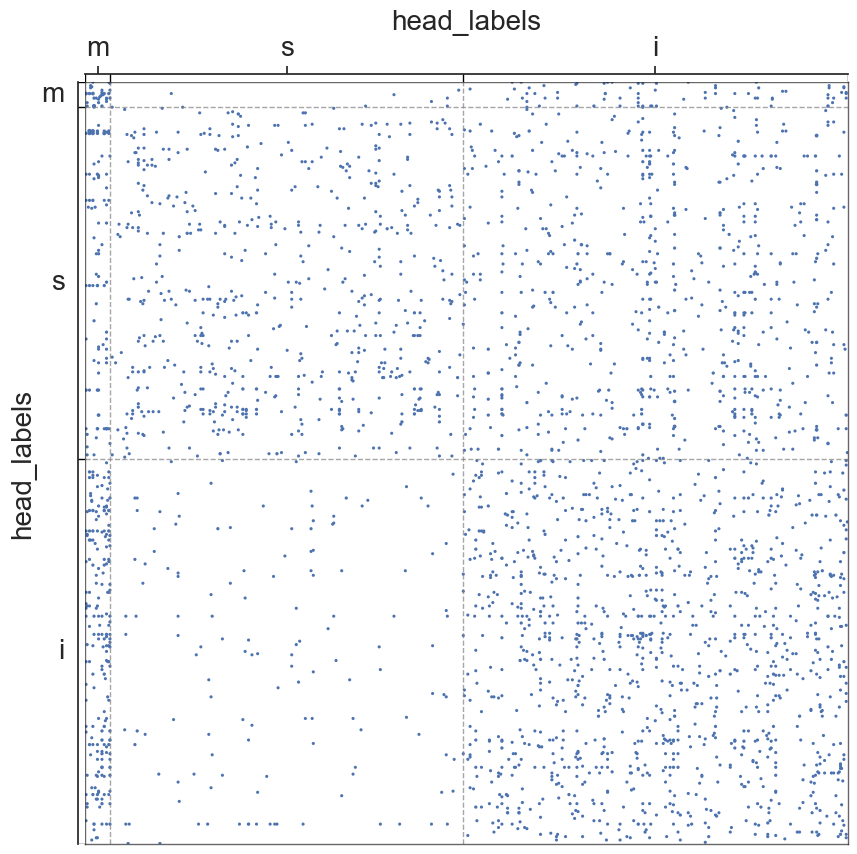

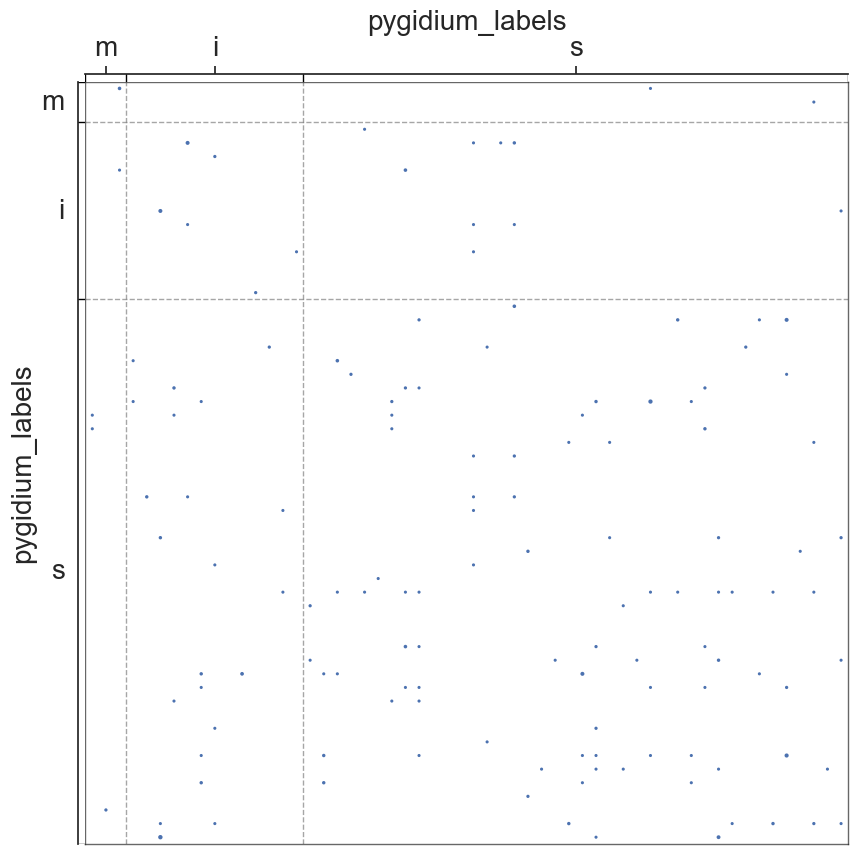

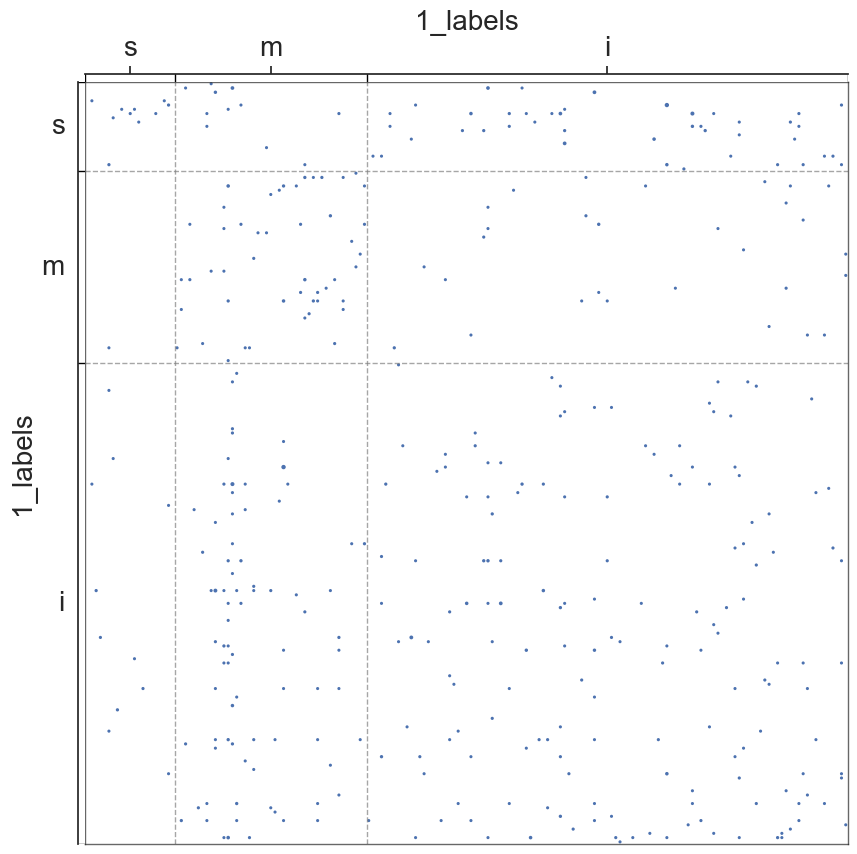

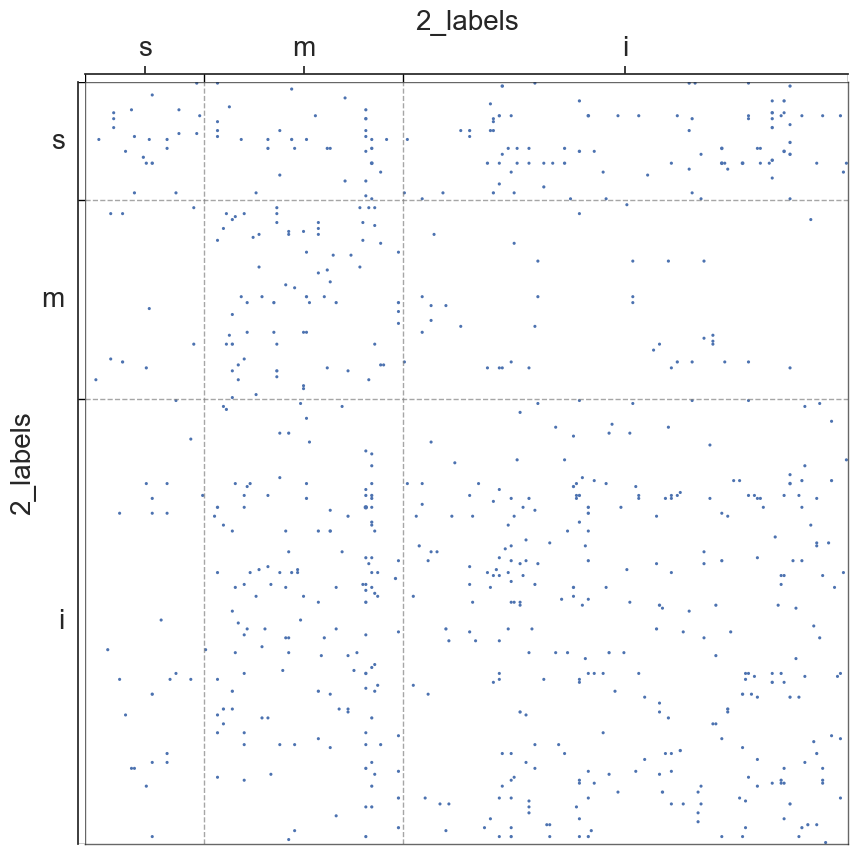

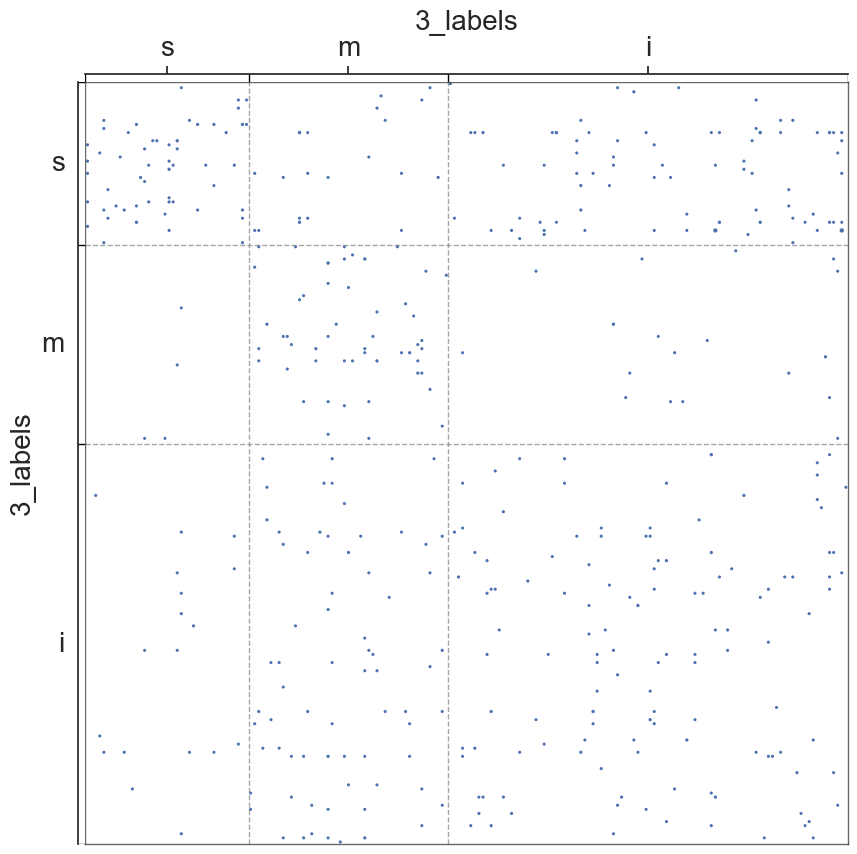

In [70]:
#scatterplots

#metadata
metas = []
for i in range(len(all_adjs)):
    metas.append(pd.DataFrame(
        data={
              "{}_labels".format(all_names[i]): all_labels[i]
        },
))

for i in range(len(all_adjs)):
    #group_order parameter - make all s have group order 0 etc
    adjplot(all_adjs[i], plot_type="scattermap", meta=metas[i], group=["{}_labels".format(all_names[i])])
    plt.savefig(new_folder / "scatterplots" / "connection_{}".format(all_names[i]))

Group Connection Test for Left and Right Hemispheres

In [71]:
stat, pval, misc = group_connection_test(hemi_adjs[0], hemi_adjs[1], hemi_labels[0], hemi_labels[1])
pval

0.0696626995269396

We do the same for all the pairwise combinations of segments

In [72]:
pairwise_labels = list(itertools.combinations(segment_labels, 2))
pairwise_adjs = list(itertools.combinations(segment_adjs, 2))
pairwise_names = list(itertools.combinations(segment_names, 2))
#initialize dataframe
zero_data = np.zeros(shape=(len(segment_names), len(segment_names)))
pval_df = pd.DataFrame(zero_data, columns=segment_names, index=segment_names)
pval_list = []
for label, adjs, name in zip(pairwise_labels, pairwise_adjs, pairwise_names):
    stat, pval, misc = group_connection_test(adjs[0], adjs[1], label[0], label[1])

    #lower limit
    thres = 1e-12
    if pval<thres:
        pval = thres
    
    pval_df[name[0]][name[1]] = pval
    pval_df[name[1]][name[0]] = pval
pval_df.to_csv(folder / "group_connection_plots" / "group_connection_test_pvals_segments.csv")
pval_df

,head,pygidium,1,2,3
head,0.000000e+00,1.000000e-12,2.702963e-08,4.181329e-10,1.000000e-12
pygidium,1.000000e-12,0.000000e+00,1.332503e-02,1.804581e-11,9.981189e-03
1,2.702963e-08,1.332503e-02,0.000000e+00,2.230677e-01,8.466542e-01
2,4.181329e-10,1.804581e-11,2.230677e-01,0.000000e+00,1.325808e-03
3,1.000000e-12,9.981189e-03,8.466542e-01,1.325808e-03,0.000000e+00


Let's use bonferroni's correction on the segment p-values to reduce the chances of obtaining false positive results since we are using multiple pairwise tests

In [73]:
#bonferroni correction for non-density adjusted p-vals
from statsmodels.stats.multitest import multipletests
np_pvals = pval_df.to_numpy().flatten()
corrected_pvals = multipletests(np_pvals)[1].reshape((len(segment_names), len(segment_names)))
pvals_df_bonferroni_corrected = pd.DataFrame(corrected_pvals, columns=segment_names, index=segment_names)
pvals_df_bonferroni_corrected

,head,pygidium,1,2,3
head,0.000000e+00,2.000000e-11,3.243555e-07,5.853861e-09,2.000000e-11
pygidium,2.000000e-11,0.000000e+00,7.733367e-02,2.887330e-10,7.711503e-02
1,3.243555e-07,7.733367e-02,0.000000e+00,6.356383e-01,9.764851e-01
2,5.853861e-09,2.887330e-10,6.356383e-01,0.000000e+00,1.317926e-02
3,2.000000e-11,7.711503e-02,9.764851e-01,1.317926e-02,0.000000e+00


Now, let's use the density adjusted version of group connection tests, which accounts for the potential difference in density across the adjs (are the group-to-group connection probabilities of one adj simply a scaled-up version of those of the other)

In [74]:
stat, pval, misc = group_connection_test(hemi_adjs[0], hemi_adjs[1], hemi_labels[0], hemi_labels[1], density_adjustment=True)
pval

0.2215230390623611

In [75]:
pairwise_labels = list(itertools.combinations(segment_labels, 2))
pairwise_adjs = list(itertools.combinations(segment_adjs, 2))
pairwise_names = list(itertools.combinations(segment_names, 2))
#initialize dataframe
zero_data = np.zeros(shape=(len(segment_names), len(segment_names)))
pval_df_density_correct = pd.DataFrame(zero_data, columns=segment_names, index=segment_names)
pval_list = []
for label, adjs, name in zip(pairwise_labels, pairwise_adjs, pairwise_names):
    stat, pval, misc = group_connection_test(adjs[0], adjs[1], label[0], label[1], density_adjustment=True)

    #lower limit
    if pval<thres:
        pval = thres
        
    pval_df_density_correct[name[0]][name[1]] = pval
    pval_df_density_correct[name[1]][name[0]] = pval
pval_df_density_correct.to_csv(folder / "group_connection_plots" / "group_connection_test_pvals_segments_density_adjust.csv")
pval_df_density_correct

,head,pygidium,1,2,3
head,0.000000e+00,0.028693,1.000000e-12,3.137590e-11,4.537271e-11
pygidium,2.869298e-02,0.000000,8.940516e-01,9.617347e-01,9.434038e-01
1,1.000000e-12,0.894052,0.000000e+00,6.005472e-01,7.561597e-01
2,3.137590e-11,0.961735,6.005472e-01,0.000000e+00,1.257010e-02
3,4.537271e-11,0.943404,7.561597e-01,1.257010e-02,0.000000e+00


Using Bonferroni's correction for the density adjusted segments:

In [76]:
np_pvals_density_correct = pval_df_density_correct.to_numpy().flatten()
corrected_pvals_density_correct = multipletests(np_pvals_density_correct)[1].reshape((len(segment_names), len(segment_names)))
pvals_df_density_corrected_bonferroni_corrected = pd.DataFrame(corrected_pvals_density_correct, columns=segment_names, index=segment_names)
pvals_df_density_corrected_bonferroni_corrected

,head,pygidium,1,2,3
head,0.000000e+00,0.294855,2.000000e-11,5.647662e-10,7.259633e-10
pygidium,2.948552e-01,0.000000,9.999986e-01,9.999986e-01,9.999986e-01
1,2.000000e-11,0.999999,0.000000e+00,9.998966e-01,9.999875e-01
2,5.647662e-10,0.999999,9.998966e-01,0.000000e+00,1.623013e-01
3,7.259633e-10,0.999999,9.999875e-01,1.623013e-01,0.000000e+00


The following functions will allow us to visualize the p-values of the segments in a heatmap, where significant p-values are denoted with an X

In [77]:
from matplotlib.transforms import Bbox
def shrink_axis(ax, scale=0.7, shift=0):
    pos = ax.get_position()
    mid = (pos.ymax + pos.ymin) / 2
    height = pos.ymax - pos.ymin
    new_pos = Bbox(
        [
            [pos.xmin, mid - scale * 0.5 * height - shift],
            [pos.xmax, mid + scale * 0.5 * height - shift],
        ]
    )
    ax.set_position(new_pos)

In [78]:
import matplotlib as mpl
cmap = mpl.colormaps["RdBu"]

In [79]:
from seaborn.utils import relative_luminance
import matplotlib as mpl
def plot_pvals(df, names, density_correct=True, bonferroni_correct=False, ax=None, thres=None, title=None):
    if ax is None:
        width_ratios = [0.5, 3, 10]
        fig, axs = plt.subplots(
            1,
            3,
            figsize=(10, 10),
            gridspec_kw=dict(
                width_ratios=width_ratios,
            ),
        )
        axs[1].remove()
        ax = axs[-1]
        cax = axs[0]
    
    plot_pvalues = np.log10(df)
    plot_pvalues.replace(-np.inf, 0, inplace=True)
    im = sns.heatmap(
        plot_pvalues,
        ax=ax,
        cmap="RdBu",
        center=0,
        square=True,
        cbar=False,
        fmt="s",
    )

    if title is not None:
        title = title
    else:
        title = "Group Connection p-values segments"
        if density_correct == True:
            title += " (density adjusted)"

        if bonferroni_correct == True:
            title += " (bonferroni corrected)"

    ax.set(ylabel="Source group", xlabel="Target group", title=title)
    ax.set(xticks=np.arange(len(names)) + 0.5, xticklabels=names)
    
    colors = im.get_children()[0].get_facecolors()
    print(im.get_children()[0])
    shrink_axis(cax, scale=0.5, shift=0.05)
    
    fig = ax.get_figure()

    
    if thres is None:
        cb = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=1,
            ticklocation="left",
        )

    #do threshold stuff: set ticks based on thres and then follow tutorial to make everything outside the threshold a diff color; then set ticks=ticks
    if thres is not None:
        cb = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=1,
            ticks=np.linspace(np.log(thres), 0, 10),
            ticklocation="left",
        )
    
    cax.set_title(r"$log_{10}$" + "\ncorrected" "\np-value", pad=20)
    
    cax.plot(
        [0, 1], [np.log10(0.05), np.log10(0.05)], zorder=100, color="black", linewidth=3
    )
    
    cax.annotate(
        r"$\alpha$",
        (0.05, np.log10(0.05)),
        xytext=(-5, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        arrowprops={"arrowstyle": "-", "linewidth": 3, "relpos": (0, 0.5)},
    )
    
    #make X's
    pad=0.2
    for idx, color in enumerate(colors):
        i, j = np.unravel_index(idx, (len(names), len(names)))
        if i!=j and np.log(df[names[i]][names[j]]) < np.log(0.05):
            lum = relative_luminance(color)
            text_color = ".15" if lum > 0.408 else "w"

            xs = [j + pad, j + 1 - pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=4)
            xs = [j + 1 - pad, j + pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=4)

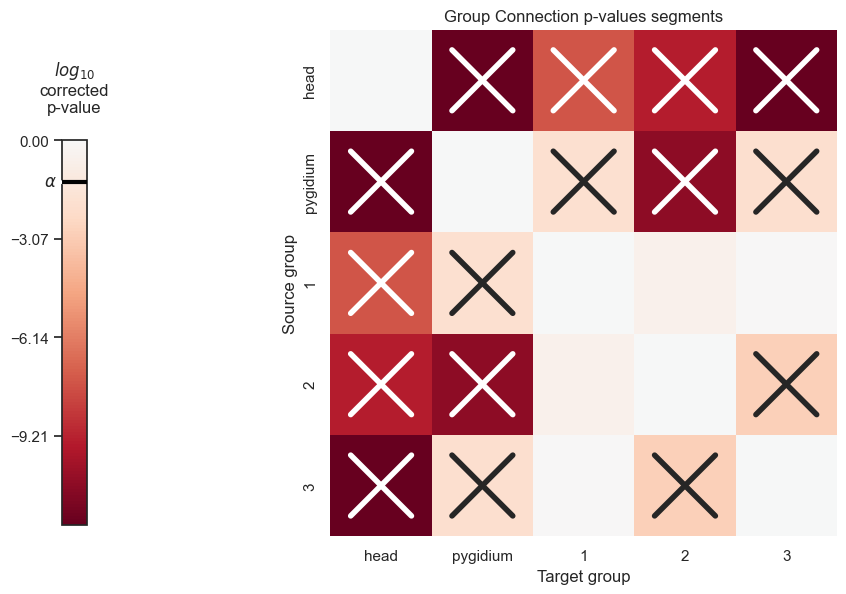

In [81]:
plot_pvals(df=pval_df, names=segment_names, density_correct=False, bonferroni_correct=False, thres=thres)
plt.savefig(new_folder / "group_connection_heatmap_segments")

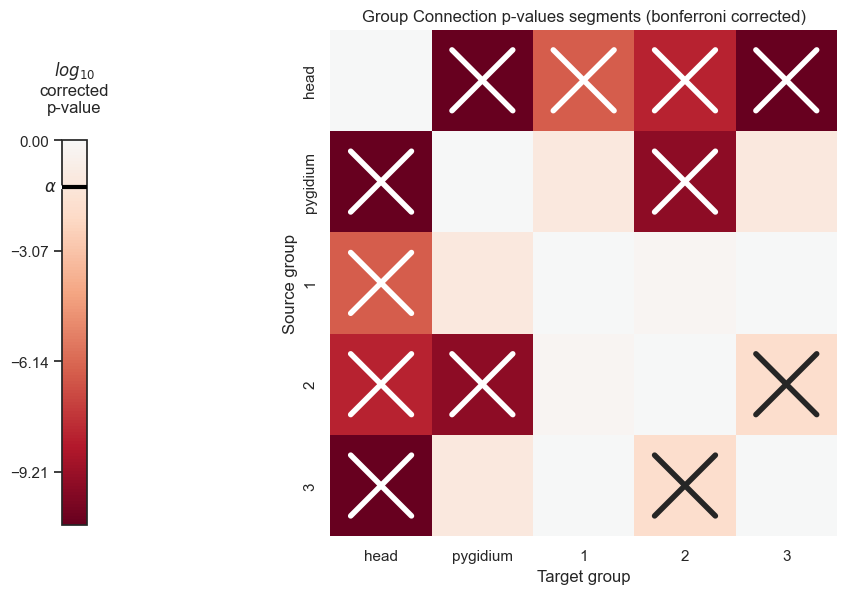

In [82]:
plot_pvals(df=pvals_df_bonferroni_corrected, names=segment_names, density_correct=False, bonferroni_correct=True, thres=thres)
plt.savefig(new_folder / "group_connection_heatmap_segments_bonferroni_corrected")

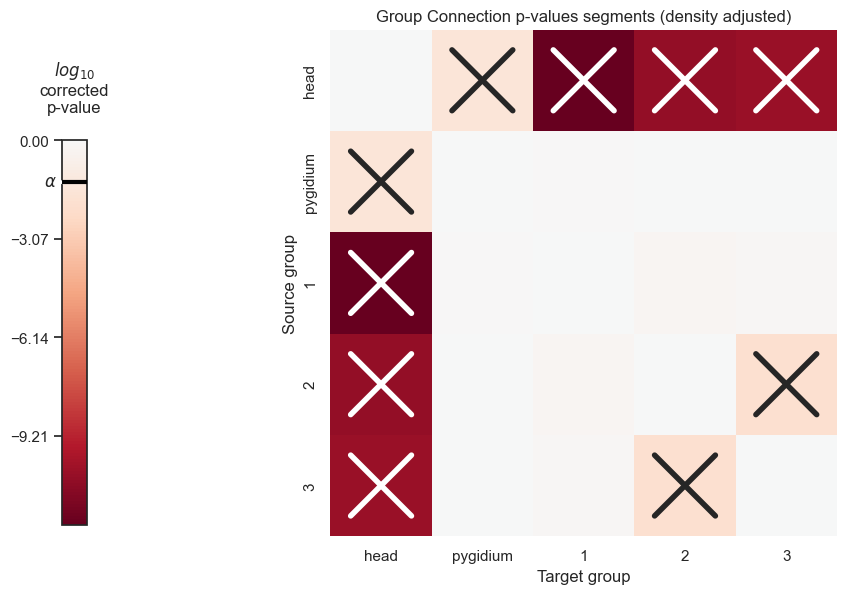

In [83]:
plot_pvals(df=pval_df_density_correct, names=segment_names, density_correct=True, thres=thres)
plt.savefig(new_folder / "group_connection_heatmap_segments_density_adjusted")

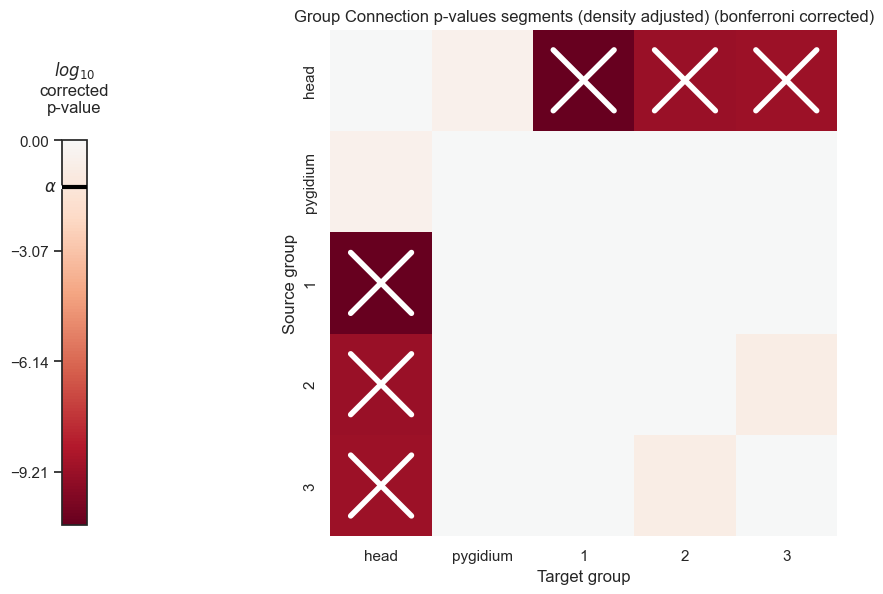

In [84]:
plot_pvals(df=pvals_df_density_corrected_bonferroni_corrected, names=segment_names, density_correct=True, bonferroni_correct=True, thres=thres)
plt.savefig(new_folder / "group_connection_heatmap_segments_density_adjusted_bonferroni_corrected")

The following section will look at comparisons of the B matrices of left vs right, and of the head, seg 1, and seg 2 using the density adjusted test

In [85]:
from pkg.plot import plot_stochastic_block_probabilities
from pkg.data import load_network_palette, load_node_palette, load_unmatched
neutral_color = sns.color_palette("Set2")[2]
network_palette, NETWORK_KEY = load_network_palette()

In [86]:
def plot_estimated_probabilities(misc):
    B1 = misc["probabilities1"]
    B2 = misc["probabilities2"]
    null_odds = misc["null_ratio"]
    B2 = B2 * null_odds
    B1_ravel = B1.values.ravel()
    B2_ravel = B2.values.ravel()
    arange = np.arange(len(B1_ravel))
    sum_ravel = B1_ravel + B2_ravel
    sort_inds = np.argsort(-sum_ravel)
    B1_ravel = B1_ravel[sort_inds]
    B2_ravel = B2_ravel[sort_inds]

    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    ax = axs[0]
    sns.scatterplot(
        x=arange,
        y=B1_ravel,
        color=network_palette["Left"],
        ax=ax,
        linewidth=0,
        s=15,
        alpha=0.5,
    )
    sns.scatterplot(
        x=arange,
        y=B2_ravel,
        color=network_palette["Right"],
        ax=ax,
        linewidth=0,
        s=15,
        alpha=0.5,
        zorder=-1,
    )
    ax.text(
        0.7,
        0.8,
        "Left",
        color=network_palette["Left"],
        transform=ax.transAxes,
    )
    ax.text(
        0.7,
        0.7,
        "Right",
        color=network_palette["Right"],
        transform=ax.transAxes,
    )
    ax.set_yscale("log")
    ax.set(
        ylabel="Estimated probability " + r"($\hat{p}$)",
        xticks=[],
        xlabel="Sorted group pairs",
    )
    ax.spines["bottom"].set_visible(False)

    ax = axs[1]
    diff = B1_ravel - B2_ravel
    yscale = np.max(np.abs(diff))
    yscale *= 1.05
    sns.scatterplot(
        x=arange, y=diff, ax=ax, linewidth=0, s=25, color=neutral_color, alpha=1
    )
    ax.axhline(0, color="black", zorder=-1)
    ax.spines["bottom"].set_visible(False)
    ax.set(
        xticks=[],
        ylabel=r"$\hat{p}_{left} - \hat{p}_{right}$",
        xlabel="Sorted group pairs",
        ylim=(-yscale, yscale),
    )
    n_greater = np.count_nonzero(diff > 0)
    n_total = len(diff)
    ax.text(
        0.3,
        0.8,
        f"Left connection stronger ({n_greater}/{n_total})",
        color=network_palette["Left"],
        transform=ax.transAxes,
    )
    n_lesser = np.count_nonzero(diff < 0)
    ax.text(
        0.3,
        0.15,
        f"Right connection stronger ({n_lesser}/{n_total})",
        color=network_palette["Right"],
        transform=ax.transAxes,
    )

    fig.text(0.02, 0.905, "A)", fontweight="bold", fontsize=30)
    fig.text(0.02, 0.49, "B)", fontweight="bold", fontsize=30)

    return fig, ax

In [87]:
#test with left and right
np_left = np.array(left_adj)
np_right = np.array(right_adj)
stat, pvalue, misc = group_connection_test(
    np_left,
    np_right,
    labels1=left_labels,
    labels2=right_labels,
    density_adjustment=True
)

(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Estimated\nedge\nprobability'}>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ left'}, xlabel='Target group', ylabel='Source group'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$c$$\\hat{B}$ right'}, xlabel='Target group'>],
       dtype=object))

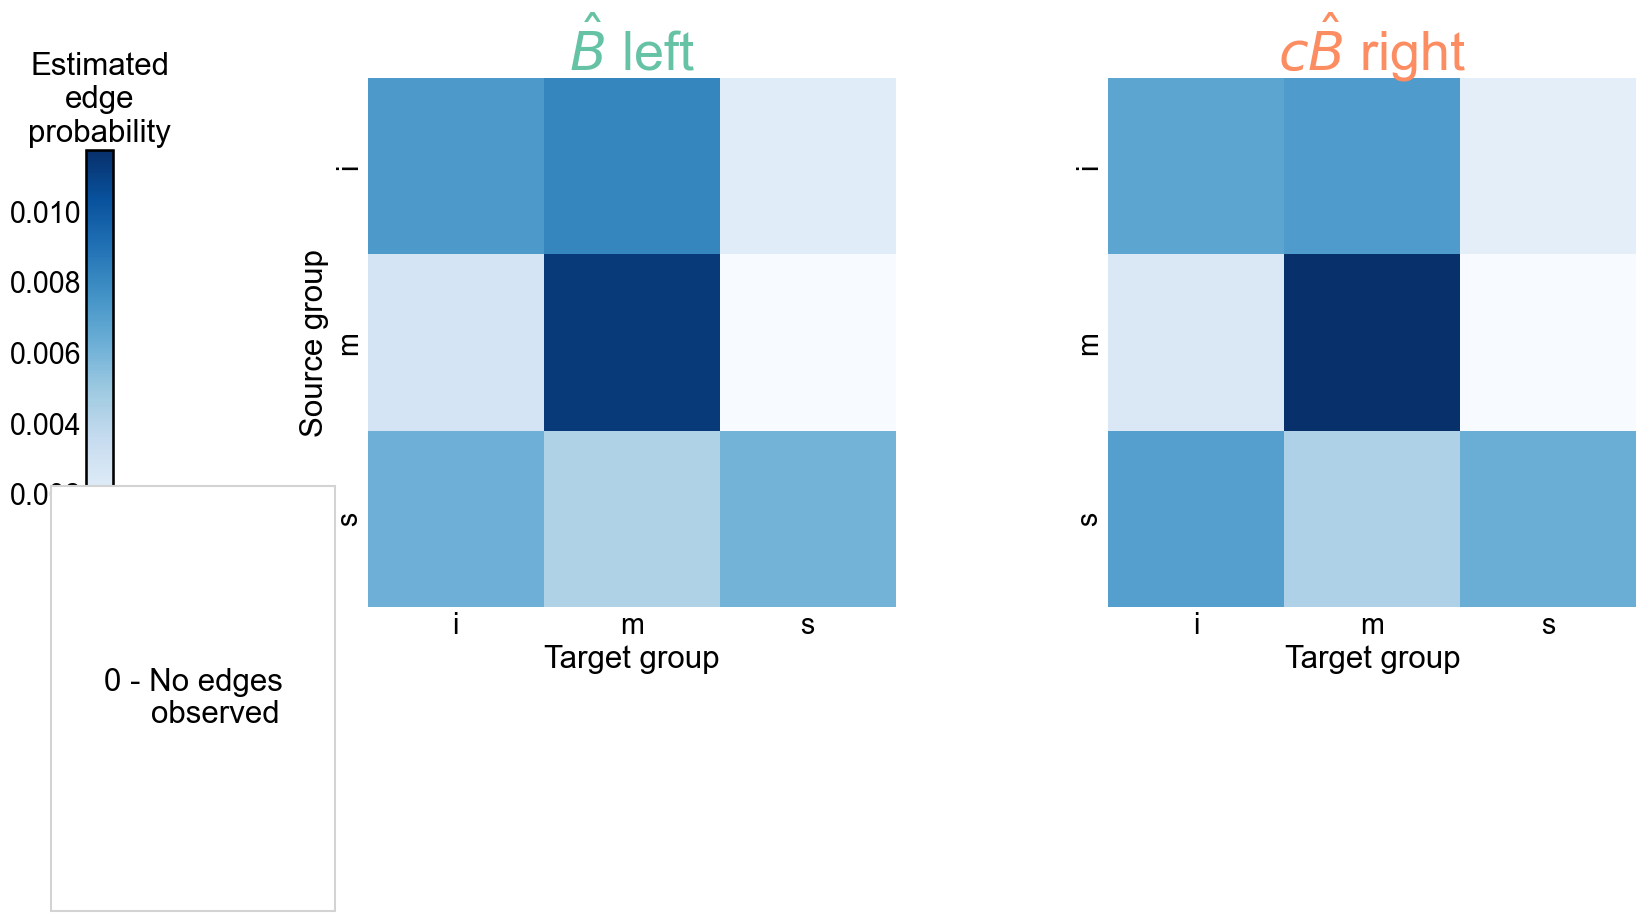

In [88]:
plot_stochastic_block_probabilities(misc, network_palette)

In [89]:
lr_pvals = misc["corrected_pvalues"]
lr_pvals 

target,i,m,s
source,,,
i,0.987105,1.0,1.0
m,1.000000,1.0,1.0
s,0.246964,1.0,1.0


In [90]:
names = ["inter", "motor", "sensor"]

def convert_misc_format(pval_df):
    zero_data = np.zeros(shape=(len(names), len(names)))
    pval_df_convert = pd.DataFrame(zero_data, columns=names, index=names)
    for i in range(len(pval_df)):
        for j in range(len(pval_df.columns)):
            pval_df_convert[names[i]][names[j]] = pval_df[names[i][0]][names[j][0]]
    
    return pval_df_convert

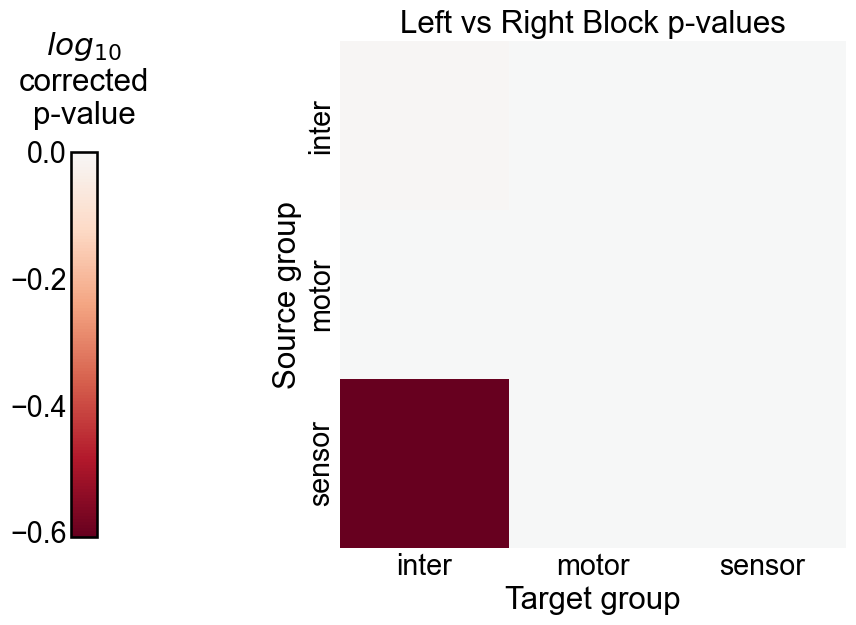

In [91]:
lr_df_convert = convert_misc_format(lr_pvals)
plot_pvals(lr_df_convert, names, title="Left vs Right Block p-values")

(<Figure size 1000x1000 with 2 Axes>,
 <AxesSubplot:xlabel='Sorted group pairs', ylabel='$\\hat{p}_{left} - \\hat{p}_{right}$'>)

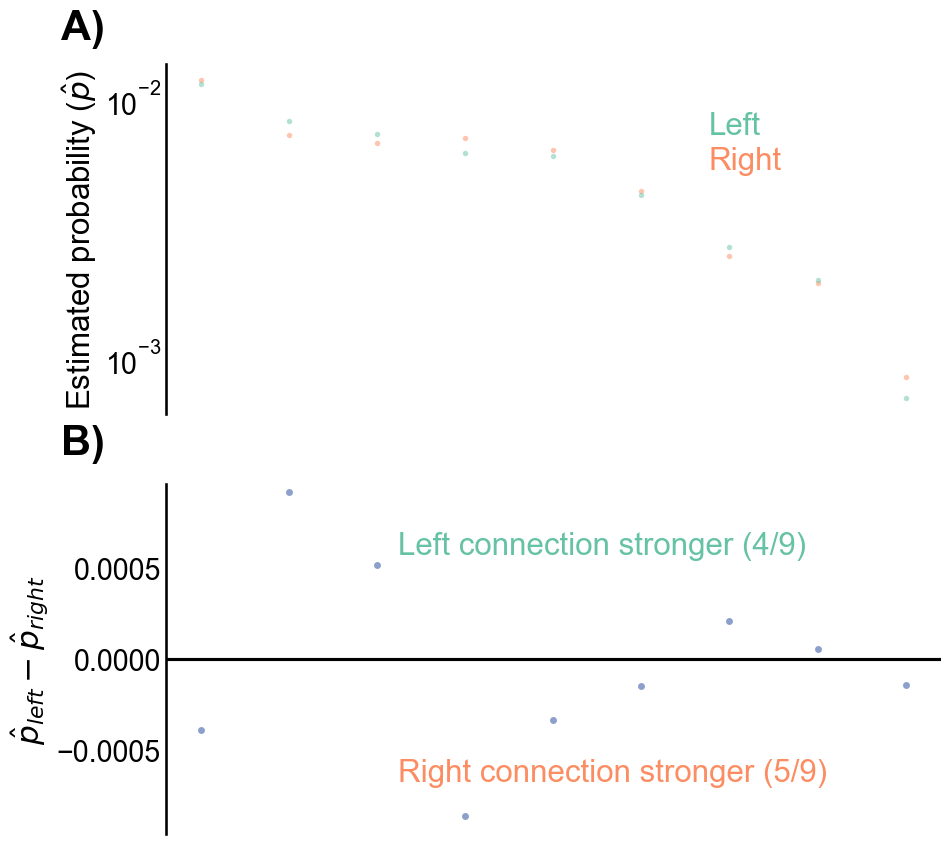

In [92]:
plot_estimated_probabilities(misc)

head vs seg 1

In [93]:
np_head = np.array(head_adj)
np_seg1 = np.array(adj_1)
stat, pvalue, misc = group_connection_test(
    np_head,
    np_seg1,
    labels1=head_labels,
    labels2=labels_1,
    density_adjustment=True
)

(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Estimated\nedge\nprobability'}>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ left'}, xlabel='Target group', ylabel='Source group'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$c$$\\hat{B}$ right'}, xlabel='Target group'>],
       dtype=object))

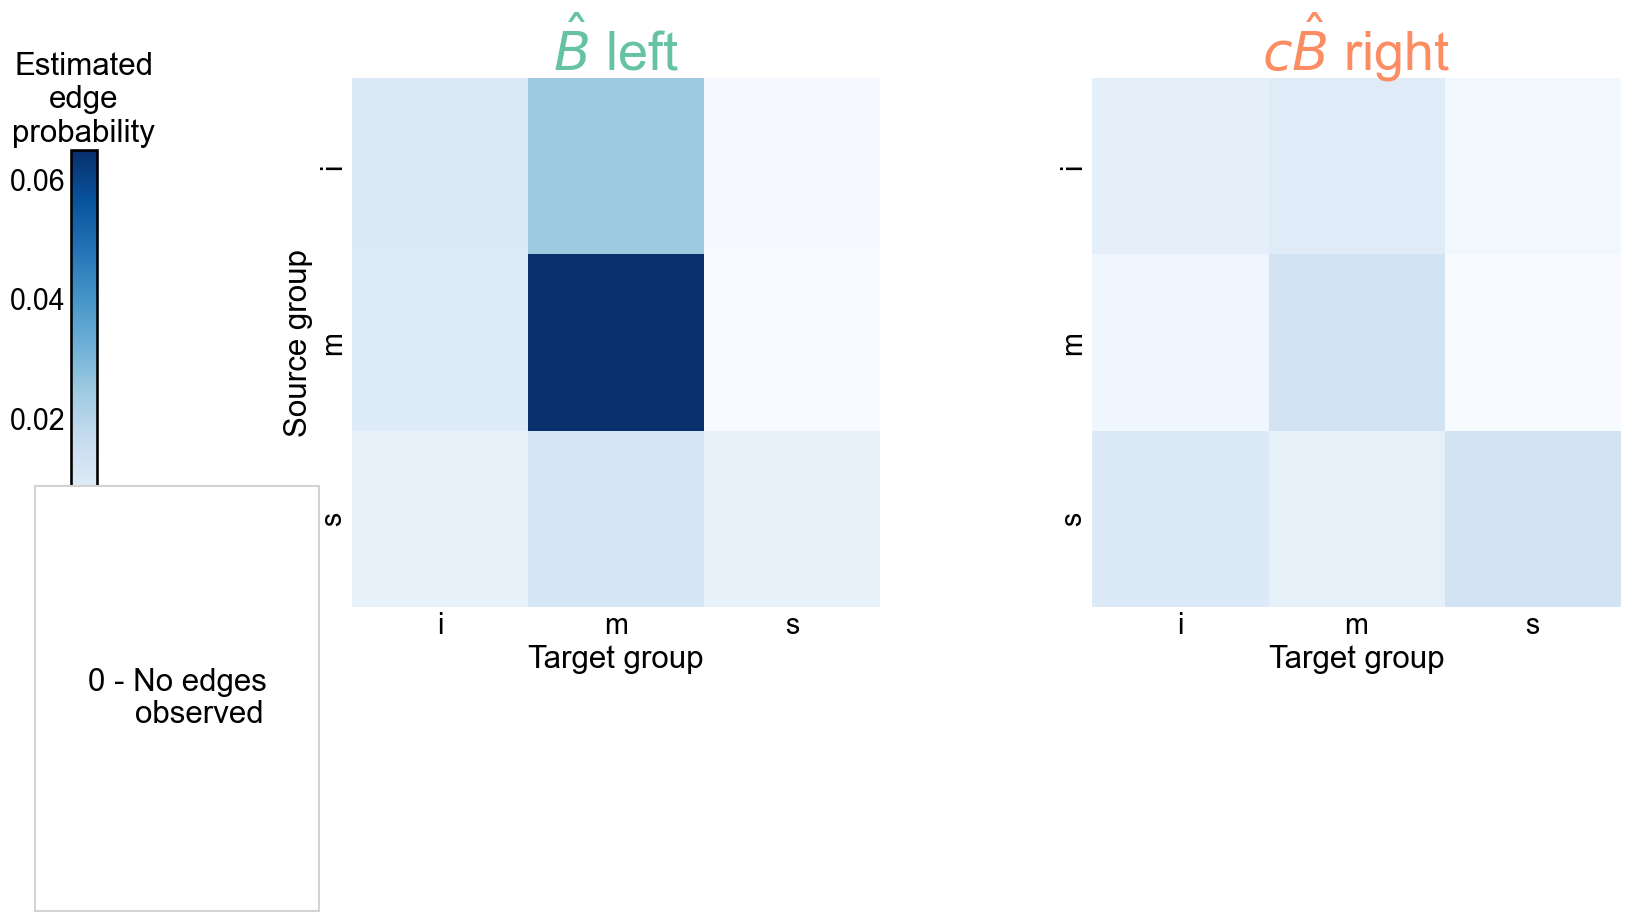

In [94]:
plot_stochastic_block_probabilities(misc, network_palette)

In [95]:
h1_pvals = misc["corrected_pvalues"]
h1_pvals

target,i,m,s
source,,,
i,1.000000e+00,3.464397e-18,0.500929
m,5.713227e-07,1.712643e-09,1.000000
s,8.094688e-02,1.000000e+00,0.330459


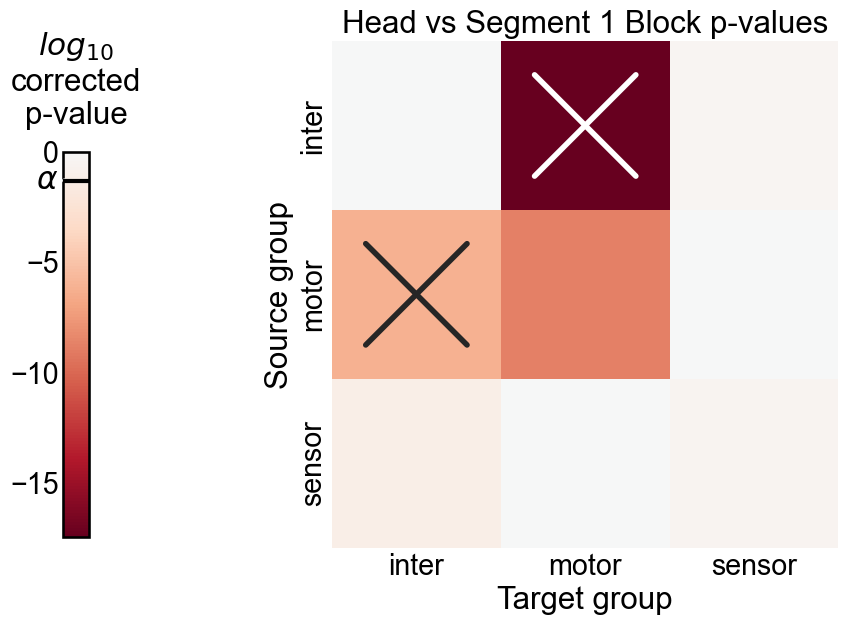

In [96]:
h1_df_convert = convert_misc_format(h1_pvals)
plot_pvals(h1_df_convert, names, title="Head vs Segment 1 Block p-values")

(<Figure size 1000x1000 with 2 Axes>,
 <AxesSubplot:xlabel='Sorted group pairs', ylabel='$\\hat{p}_{left} - \\hat{p}_{right}$'>)

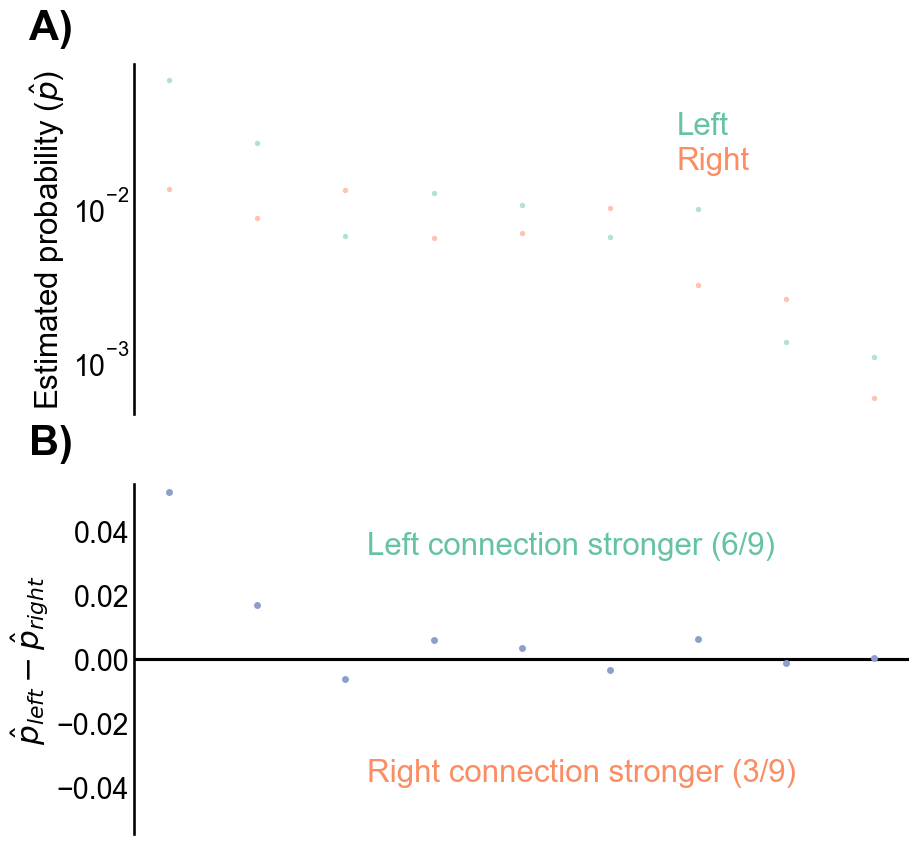

In [97]:
plot_estimated_probabilities(misc)

seg 1 vs seg 2

In [98]:
np_seg1 = np.array(adj_1)
np_seg2 = np.array(adj_2)
stat, pvalue, misc = group_connection_test(
    np_seg1,
    np_seg2,
    labels1=labels_1,
    labels2=labels_2,
    density_adjustment=True
)

(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Estimated\nedge\nprobability'}>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ left'}, xlabel='Target group', ylabel='Source group'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$c$$\\hat{B}$ right'}, xlabel='Target group'>],
       dtype=object))

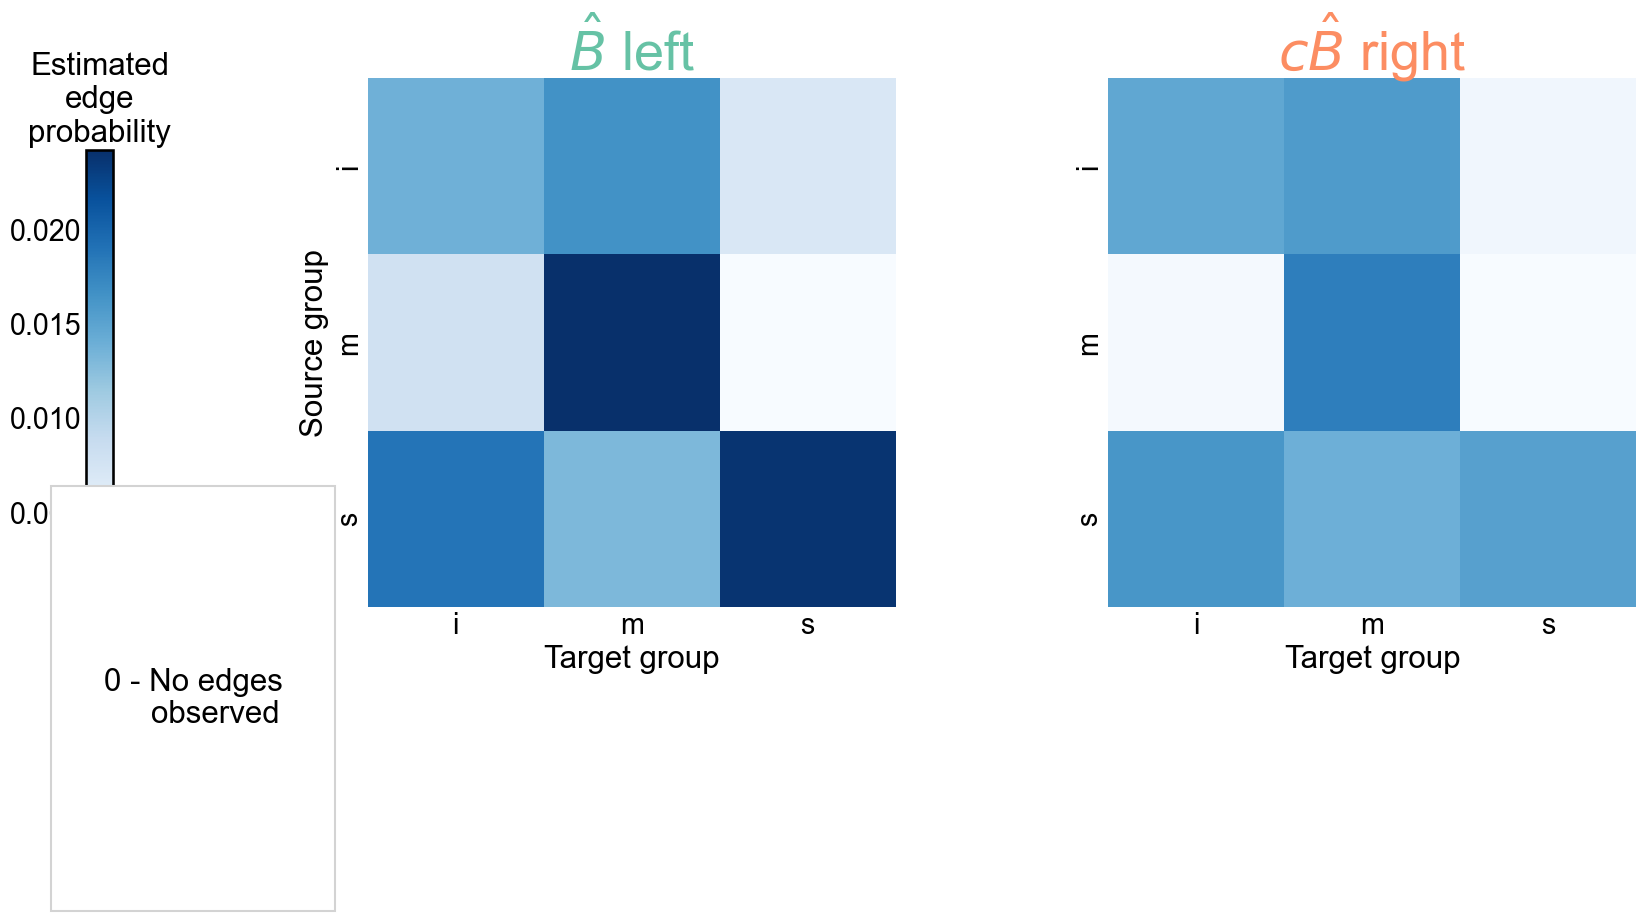

In [99]:
plot_stochastic_block_probabilities(misc, network_palette)

In [100]:
seg12_pvals = misc["corrected_pvalues"]
seg12_pvals

target,i,m,s
source,,,
i,0.872427,1.0,1.0
m,1.000000,1.0,1.0
s,1.000000,1.0,1.0


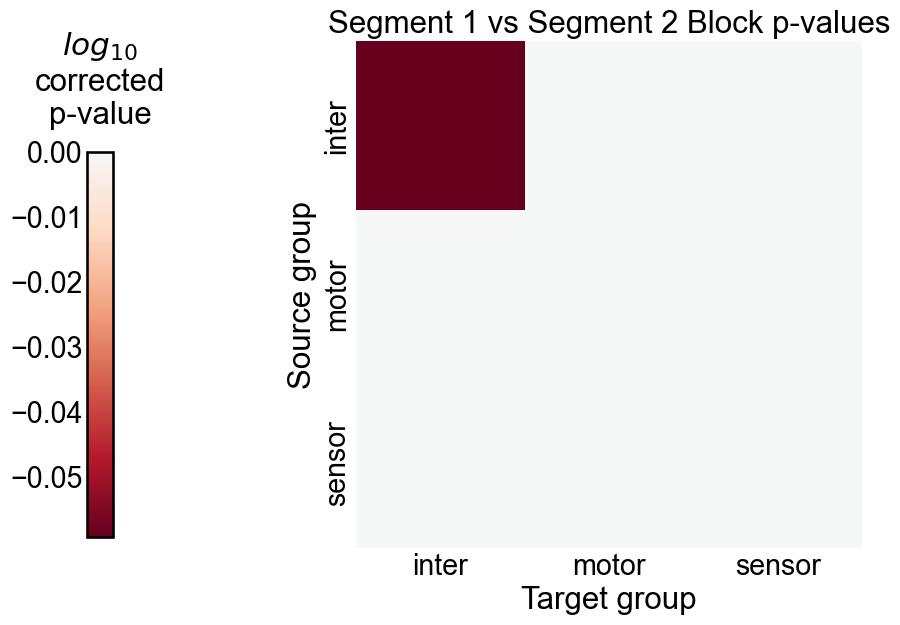

In [101]:
seg12_df_convert = convert_misc_format(seg12_pvals)
plot_pvals(seg12_df_convert, names, title="Segment 1 vs Segment 2 Block p-values")

(<Figure size 1000x1000 with 2 Axes>,
 <AxesSubplot:xlabel='Sorted group pairs', ylabel='$\\hat{p}_{left} - \\hat{p}_{right}$'>)

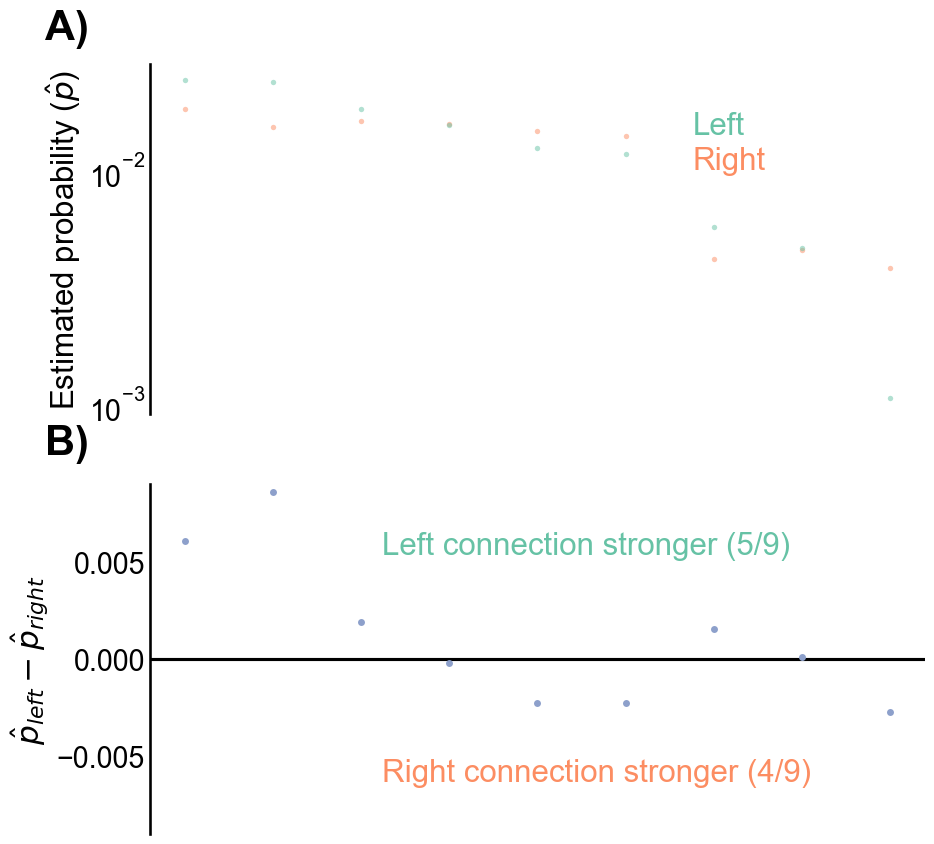

In [102]:
plot_estimated_probabilities(misc)